# Analysis of Batch Effects

This notebook contains the analysis of batch effects in the data. The pancreatic cancer dataset is split into batches based on three separate slides it was acquired in. BBKNN and ComBat are combined with MAGIC denoising to tackle batch effects together with the general technical noise/sparsity.


In [1]:
import os
import scanpy as sc
import numpy as np 
import magic

import graphtools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import bbknn
from tqdm import tqdm
import sklearn
from joblib import Parallel, delayed

import bbmagic as bm
# Matplotlib command for Jupyter notebooks only
%matplotlib inline

2023-06-24 11:10:15.210379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# importing custom functions for imputation and evaluation
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow,
)
from sc_imputation_denoising.imputation.simulation import (
    get_dropout_rate
)

import sc_imputation_denoising.imputation.constants as const


IE version 1.2


In [35]:
dataset= "Lx_Pancreatic_Cancer"
adata= sc.read(f'/home/mklein/Dropouts/data/{dataset}.h5ad')

get_dropout_rate(adata, layer=None)

adata.obs['dataset'] = 'none'
adata.obs['batch'] = adata.obs['dataset_2']
adata.obs['sample'] = adata.obs['well']
#adata.obs['condition'] = adata.obs['dataset_0']

get_dropout_rate(adata, layer=None)
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=83)
sc.pp.filter_genes(adata, min_cells=3137)
get_dropout_rate(adata, layer=None)
print(adata.shape)

Global dropout rate: 93.12 Percent
Global dropout rate: 93.12 Percent
(27017, 1890)
Global dropout rate: 49.82 Percent
(15593, 353)


In [36]:
adata.obs['dataset'] = 'none'
adata.obs['batch'] = adata.obs['dataset_2']
adata.obs['sample'] = adata.obs['well']
metadata = pd.read_csv('/home/mklein/Dropouts/data/PancreaticCancer_datasets.csv')
metadata['sample'] = "S" + metadata['slide'].astype(str) + "_W" + metadata['well'].astype(str)
merge_df = pd.merge(adata.obs, metadata[['sample', 'condition']], how="inner", on="sample")
merge_df.index = adata.obs_names
adata.obs = merge_df
adata.var['fdr'] = 1

In [37]:
wflow = evaluation_workflow(
    adata = adata,
    sample_col = 'well',
    batch_col='dataset_2'
)

sc.pp.normalize_total(wflow.dataset, target_sum=1e4)
sc.pp.log1p(wflow.dataset)
get_dropout_rate(adata, layer=None)
print(adata.shape)

Global dropout rate: 49.82 Percent
Global dropout rate: 49.82 Percent
(15593, 353)


In [38]:
wflow.analysis_ions = wflow._get_differential_ions(n_ions=4)
sig_ions_table = []
for (k, st) in adata.var.loc[wflow.analysis_ions, 'moleculeNames'].to_dict().items():
    li = ast.literal_eval(st)
    for ind, i in enumerate(li):
        sig_ions_table.append({'formula': k, 'annotation':ind+1, 'molecule': i})
pd.DataFrame(sig_ions_table).set_index(['formula', 'annotation'])

,,molecule
formula,annotation,
C46H91O8P+K,1,C46H91O8P
C49H87O7P+Na,1,C49H87O7P
C39H81N2O6P+Na,1,C39H81N2O6P
C34H67NO2+H,1,C34H67NO2
C47H93N2O6P+Na,1,C47H93N2O6P
C26H54NO7P+Na,1,C26H54NO7P
C39H81N2O6P+H,1,C39H81N2O6P
C43H75O8P+H,1,C43H75O8P
C41H77O8P+Na,1,C41H77O8P


In [39]:
" | ".join(list(pd.DataFrame(sig_ions_table)['molecule']))

'C46H91O8P | C49H87O7P | C39H81N2O6P | C34H67NO2 | C47H93N2O6P | C26H54NO7P | C39H81N2O6P | C43H75O8P | C41H77O8P | C33H62O4 | C44H86NO7P | C35H67O8P | C40H82NO7P | C45H79NO4 | C47H83NO8 | C46H84NO8P'

In [40]:
endogenous_ions = ['C26H54NO7P', 'C44H86NO7P', 'C46H84NO8P', 'C39H81N2O6P']#, 'C41H77O8P', 'C43H75O8P']
sg_df = pd.DataFrame(sig_ions_table)
sg_df = sg_df[sg_df['molecule'].isin(endogenous_ions)]
sg_df

,formula,annotation,molecule
2,C39H81N2O6P+Na,1,C39H81N2O6P
5,C26H54NO7P+Na,1,C26H54NO7P
6,C39H81N2O6P+H,1,C39H81N2O6P
10,C44H86NO7P+H,1,C44H86NO7P
15,C46H84NO8P+H,1,C46H84NO8P


In [41]:
wflow.analysis_ions = list(sg_df['formula'])

In [10]:
#i_e.analysis_ions = [i_e.analysis_ions[i] for i in [0, 1, 2, 6]]

In [42]:
wflow.simulate_dropouts(n_logspace=0)

Generated 1 datasets with increasing dropout rates: 0.4981597211939911
simulating dropout rates [0.4981597211939911] with method mcar


In [58]:
t_steps = [1, 2, 3, 5, 8]
knn = 3

In [59]:
for k,adata in wflow.dataset_dict.items():
    
    for t in t_steps:
        bm.bb_magic(adata, t=t, layer_from='ctrl', layer_to=f"bbmagic_{t}")

Running MAGIC on 15593 cells and 353 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 19.44 seconds.


In [19]:
for k,adata in wflow.dataset_dict.items():
    
    for t in t_steps:
        bm.bb_magic(adata, t=t, layer_from='ctrl', layer_to=f"bbmagic_angular_{t}", bbknn_kws={'metric':'angular'})

Running MAGIC on 15593 cells and 353 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 15.82 seconds.


In [20]:
for k,adata in wflow.dataset_dict.items():
    
    adata_combat = adata.copy()
#     adata_combat.X = adata_combat.layers['ctrl']
    sc.pp.combat(adata_combat, key='batch')
    adata.layers['combat'] = adata_combat.X

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [16]:
for k,adata in wflow.dataset_dict.items():
        
    del adata.obsm, adata.obsp
    magic_op = magic.MAGIC()
    
    sc.tl.pca(adata)
    bbknn.bbknn(adata, 
        batch_key='dataset',
        neighbors_within_batch = knn,
        n_pcs = 100
    )
    graph = graphtools.graphs.TraditionalGraph(adata.obsp['connectivities'].todense(), precomputed='adjacency', decay=None)
    graph.build_kernel()
    graph._kernel = np.asarray(graph._kernel)
    magic_op.fit(adata.to_df(layer="ctrl"), graph = graph)
        
    for t in t_steps:
        magic_op.set_params(t=t)
        adata.layers[f"MAGIC_dc_{t}"] = magic_op.transform(adata.to_df(layer="ctrl"))

Running MAGIC on 5112 cells and 631 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.21 seconds.
Running MAGIC on 5112 cells and 631 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.42 seconds.
Running MAGIC on 5112 cells and 631 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.56 seconds.
Running MAGIC on 5112 cells and 631 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.28 seconds.
Running MAGIC on 5112 cells and 631 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 1.56 seconds.


In [21]:
for k,adata in wflow.dataset_dict.items():
    
    magic_op = magic.MAGIC(knn=knn)
    magic_op.fit(adata.to_df(layer="ctrl"))
  
    for t in t_steps:
        magic_op.set_params(t=t)
        adata.layers[f"MAGIC_t{t}"] = magic_op.transform(adata.to_df(layer="ctrl"))

Running MAGIC on 15593 cells and 353 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 2.83 seconds.
  Calculating KNN search...
  Calculated KNN search in 26.48 seconds.
  Calculating affinities...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 1017 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated affinities in 26.34 seconds.
Calculated graph and diffusion operator in 55.77 seconds.
Calculating imputation...
Calculated imputation in 0.23 seconds.


In [89]:
for k,adata in wflow.dataset_dict.items():
    
    adata_combat = adata.copy()
#     adata_combat.X = adata_combat.layers['ctrl']
    sc.pp.combat(adata_combat, key='batch')
    adata_combat.layers['ctrl'] = adata_combat.X

    magic_op = magic.MAGIC(knn=knn)
    magic_op.fit(adata_combat.to_df(layer="ctrl"))
  
    for t in t_steps:
        magic_op.set_params(t=t)
        adata.layers[f"combat_MAGIC_t{t}"] = magic_op.transform(adata_combat.to_df(layer="ctrl"))

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Running MAGIC on 15593 cells and 353 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 3.53 seconds.
  Calculating KNN search...
  Calculated KNN search in 27.96 seconds.
  Calculating affinities...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 1001 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated affinities in 27.09 seconds.
Calculated graph and diffusion operator in 58.60 seconds.
Calculating imputation...
Calculated imputation in 0.23 seconds.


In [61]:
wflow.dataset_dict[wflow.baseline_key].layers

Layers with keys: ctrl, bbmagic_1, bbmagic_2, bbmagic_3, bbmagic_5, bbmagic_8

In [46]:
wflow.save_to_pickle(save_to='/home/mklein/Dropouts/batch_effects/incr_batch_pickle.pkl')

In [63]:
wflow.init_analysis(precalc_umap=False)

In [68]:
def _analyse_imputation(params):
        l = params
        adata = l['adata']
        ad_ctrl = wflow.dataset.X
        sc.pp.pca(adata)
        sc.pp.neighbors(adata, n_neighbors=50)
        sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
        
        u_df = sc.get.obs_df(
            adata, 
            keys=[const.SAMPLE_COL, const.BATCH_COL, const.CONDITION_COL] + wflow.analysis_ions, 
            obsm_keys=[("X_umap", 0), ("X_umap", 1)]
        )   
        
        u_df['imputation'] = l['imputation']
        u_df['dr'] = l['dropout_ratio']
        return u_df
    
df = wflow.analyse_imputation(function = _analyse_imputation, test_subset=None, verbose=50)
df

100%|██████████| 6/6 [00:01<00:00,  4.37it/s]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.



2023-06-24 13:05:19.013664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 13:05:19.040109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 13:05:19.051373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2

[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:  2.6min remaining:  5.3min
IE version 1.2
IE version 1.2
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  2.8min remaining:  2.8min
IE version 1.2
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:  2.8min remaining:  1.4min
IE version 1.2
IE version 1.2
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  2.9min finished
IE version 1.2


,sample,batch,condition,C39H81N2O6P+Na,C26H54NO7P+Na,C39H81N2O6P+H,C44H86NO7P+H,C46H84NO8P+H,X_umap-0,X_umap-1,imputation,dr,dropout_ratio
cell_id,,,,,,,,,,,,,
21_S3_W5,S3_W5,S3,MiaPaca2,0.000000,0.000000,0.000000,0.000000,0.000000,14.232056,5.802154,ctrl,0.5_baseline,0.5
24_S3_W5,S3_W5,S3,MiaPaca2,0.000000,0.000000,0.000000,0.000000,0.000000,14.453305,6.271751,ctrl,0.5_baseline,0.5
28_S3_W5,S3_W5,S3,MiaPaca2,0.000000,0.000000,0.000000,0.000000,0.000000,13.140661,4.372003,ctrl,0.5_baseline,0.5
29_S3_W5,S3_W5,S3,MiaPaca2,0.000000,0.000000,0.000000,0.000000,0.000000,11.755520,4.261502,ctrl,0.5_baseline,0.5
31_S3_W5,S3_W5,S3,MiaPaca2,0.000000,4.232676,0.000000,0.000000,0.000000,11.478874,4.876318,ctrl,0.5_baseline,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143_S1_W5,S1_W5,S1,MiaPaca2,0.155827,0.764834,0.149114,0.330862,2.677682,10.075467,11.021708,bbmagic_8,0.5_baseline,0.5
2146_S1_W5,S1_W5,S1,MiaPaca2,0.228960,0.500370,0.274053,0.733430,2.654378,6.854240,11.166370,bbmagic_8,0.5_baseline,0.5
2148_S1_W5,S1_W5,S1,MiaPaca2,0.121578,0.804261,0.104773,0.101076,2.342514,14.631831,10.961484,bbmagic_8,0.5_baseline,0.5


In [69]:
df.to_csv('/home/mklein/Dropouts/batch_effects/incr_batch_df.csv')

In [94]:
wflow.dataset_dict[wflow.baseline_key].copy()

AnnData object with n_obs × n_vars = 15593 × 353
    obs: 'center_x', 'center_y', 'cell_area', 'cell_sampling_area', 'cell_sampling_ratio', 'cell_nearest_am_distance', 'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'local_centroid-0', 'local_centroid-1', 'area', 'filled_area', 'solidity', 'perimeter', 'eccentricity', 'euler_number', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'major_axis_length', 'minor_axis_length', 'weighted_moments_central-0-0-DAPI',

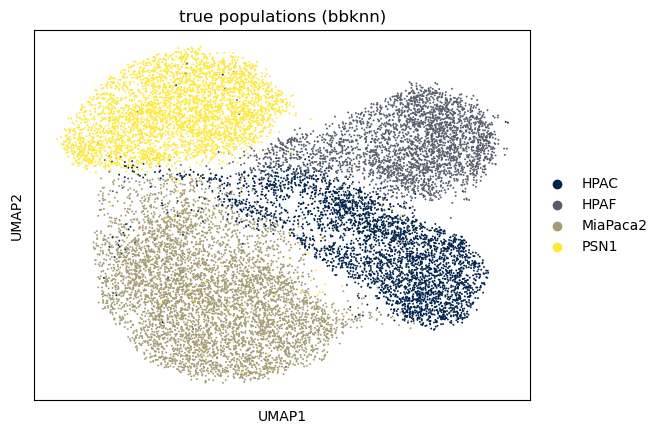

In [53]:
ad_raw = wflow.dataset_dict[wflow.baseline_key].copy()

bbknn.bbknn(ad_raw, 
    batch_key='dataset_2',
    neighbors_within_batch = 3
)
sc.tl.umap(ad_raw, min_dist=0.5, spread=1.0, random_state=1, n_components=2)


In [95]:
df_bbknn = df[df['imputation'] == "ctrl"].copy()
df_bbknn['imputation'] = "bbknn"
df_bbknn[['X_umap-0', 'X_umap-1']] = ad_raw.obsm['X_umap']
df_integrated = pd.concat([df, df_bbknn])


In [170]:
df_integrated.to_csv('/home/mklein/Dropouts/batch_effects/pancreatic_cancer_umaps.csv')

In [ ]:
wflow.save_to_pickle(save_to='/home/mklein/Dropouts/batch_effects/batch_pickle.pkl')

In [ ]:
df_integrated = pd.read_csv('/home/mklein/Dropouts/batch_effects/pancreatic_cancer_umaps.csv')

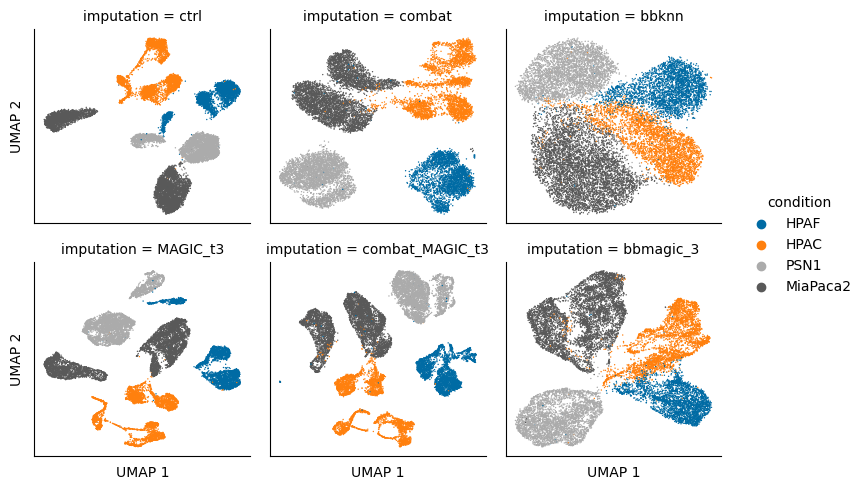

In [160]:
plt.style.use('tableau-colorblind10')

grid = sns.relplot(
    data=df_integrated, 
    col='imputation', col_wrap=3, col_order=['ctrl', 'combat', 'bbknn', 'MAGIC_t3', 'combat_MAGIC_t3', 'bbmagic_3'],
    hue='condition', hue_order=const.COND_ORDER[dataset],
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False), 
    height=2.5, 
    x='X_umap-0', y='X_umap-1', s=1, linewidth=0
)
for ax in grid.axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid.set_xlabels("UMAP 1")
grid.set_ylabels("UMAP 2")
grid.tight_layout()

grid.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_conditions.pdf")


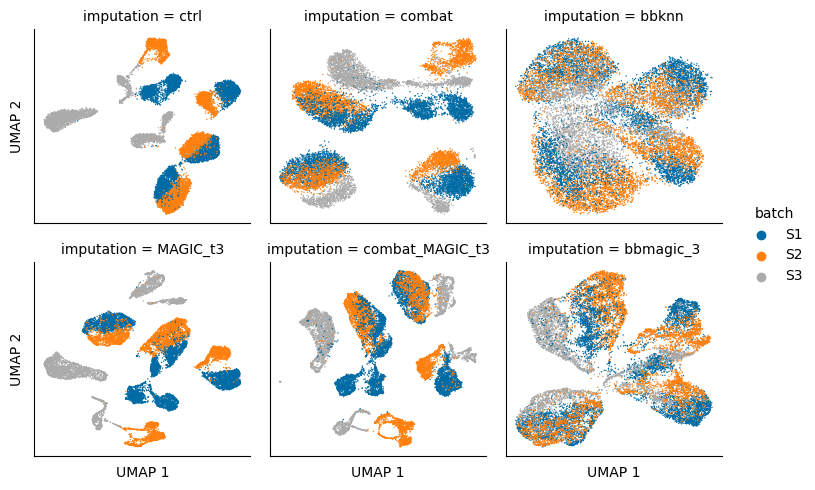

In [161]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')

grid = sns.relplot(
    data=df_integrated, 
    col='imputation', col_wrap=3, col_order=['ctrl', 'combat', 'bbknn', 'MAGIC_t3', 'combat_MAGIC_t3', 'bbmagic_3'],
    hue='batch', 
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False), 
    height=2.5, 
    x='X_umap-0', y='X_umap-1', s=1, linewidth=0
)
for ax in grid.axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid.set_xlabels("UMAP 1")
grid.set_ylabels("UMAP 2")
grid.tight_layout()

grid.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_batches.pdf")


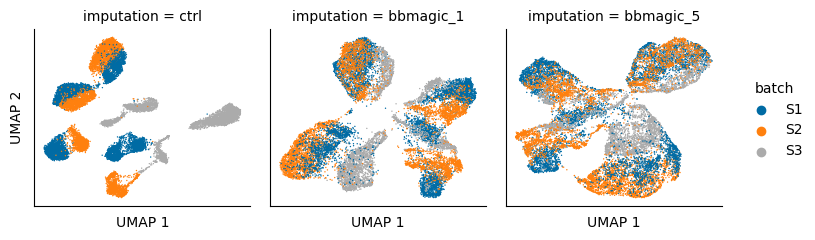

In [72]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')

grid = sns.relplot(
    data=df, 
    col='imputation', col_wrap=3, col_order=['ctrl', 'bbmagic_1', 'bbmagic_5'],
    hue='batch', 
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False), 
    height=2.5, 
    x='X_umap-0', y='X_umap-1', s=1, linewidth=0
)
for ax in grid.axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid.set_xlabels("UMAP 1")
grid.set_ylabels("UMAP 2")
grid.tight_layout()

grid.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_batches_incr.pdf")


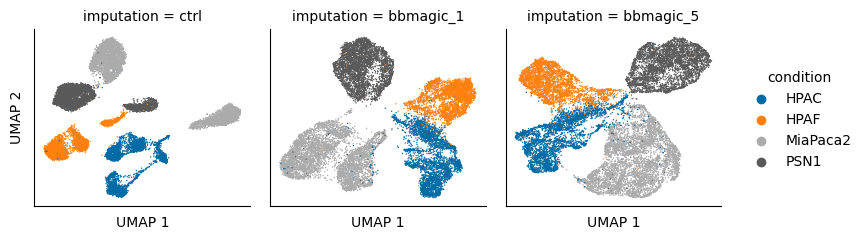

In [73]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')

grid = sns.relplot(
    data=df, 
    col='imputation', col_wrap=3, col_order=['ctrl', 'bbmagic_1', 'bbmagic_5'],
    hue='condition', 
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False), 
    height=2.5, 
    x='X_umap-0', y='X_umap-1', s=1, linewidth=0
)
for ax in grid.axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

grid.set_xlabels("UMAP 1")
grid.set_ylabels("UMAP 2")
grid.tight_layout()

grid.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_cond_incr.pdf")


In [ ]:
def _analyse_batch_effects(params):
    l = params
    adata = l['adata'].copy()

    
    all_ions_table = sc.get.obs_df(adata, keys=['batch', 'condition'] + list(adata.var_names))
    
    batch_list = []
    for cond in adata.obs[const.CONDITION_COL].value_counts().index:
        ions_table_cond = all_ions_table[all_ions_table[const.CONDITION_COL] == cond].copy()
        ions_table_cond.drop(const.CONDITION_COL, axis=1, inplace=True)
        corr_matrix = ions_table_cond.set_index(['batch'], append=True).T.corr()
        corr_matrix.index = corr_matrix.index.rename(['cell_id_2', 'batch_2'])
        # convert correlation matrix into long table and remove pairs of same cells
        corr_table = corr_matrix.reset_index().melt(id_vars=['cell_id_2', 'batch_2'])
        corr_table = corr_table[corr_table['cell_id'] != corr_table['cell_id_2']]
        # calculate coefficient of determination and batch over
        corr_table['same_batch'] = corr_table['batch'] == corr_table['batch_2']
        corr_table.drop(['cell_id_2', 'batch_2', 'cell_id', 'batch'], axis=1, inplace=True)
        corr_table[const.CONDITION_COL] = cond
        batch_list.append({
            'condition': cond,
            'median_ratio': corr_table.loc[corr_table['same_batch'] == False, 'value'].median() / corr_table.loc[corr_table['same_batch'] == True, 'value'].median(),
            'mean_ratio': corr_table.loc[corr_table['same_batch'] == False, 'value'].mean() / corr_table.loc[corr_table['same_batch'] == True, 'value'].mean()
        })
        # batch_list.append(corr_table)

    batch_df = pd.DataFrame(batch_list)

    batch_df['imputation'] = l['imputation']
    batch_df['dr'] = l['dropout_ratio']

    return batch_df

batch_effect_df = wflow.analyse_imputation(function = _analyse_batch_effects, test_subset=None, n_jobs=48)

100%|██████████| 30/30 [00:00<00:00, 46.80it/s]


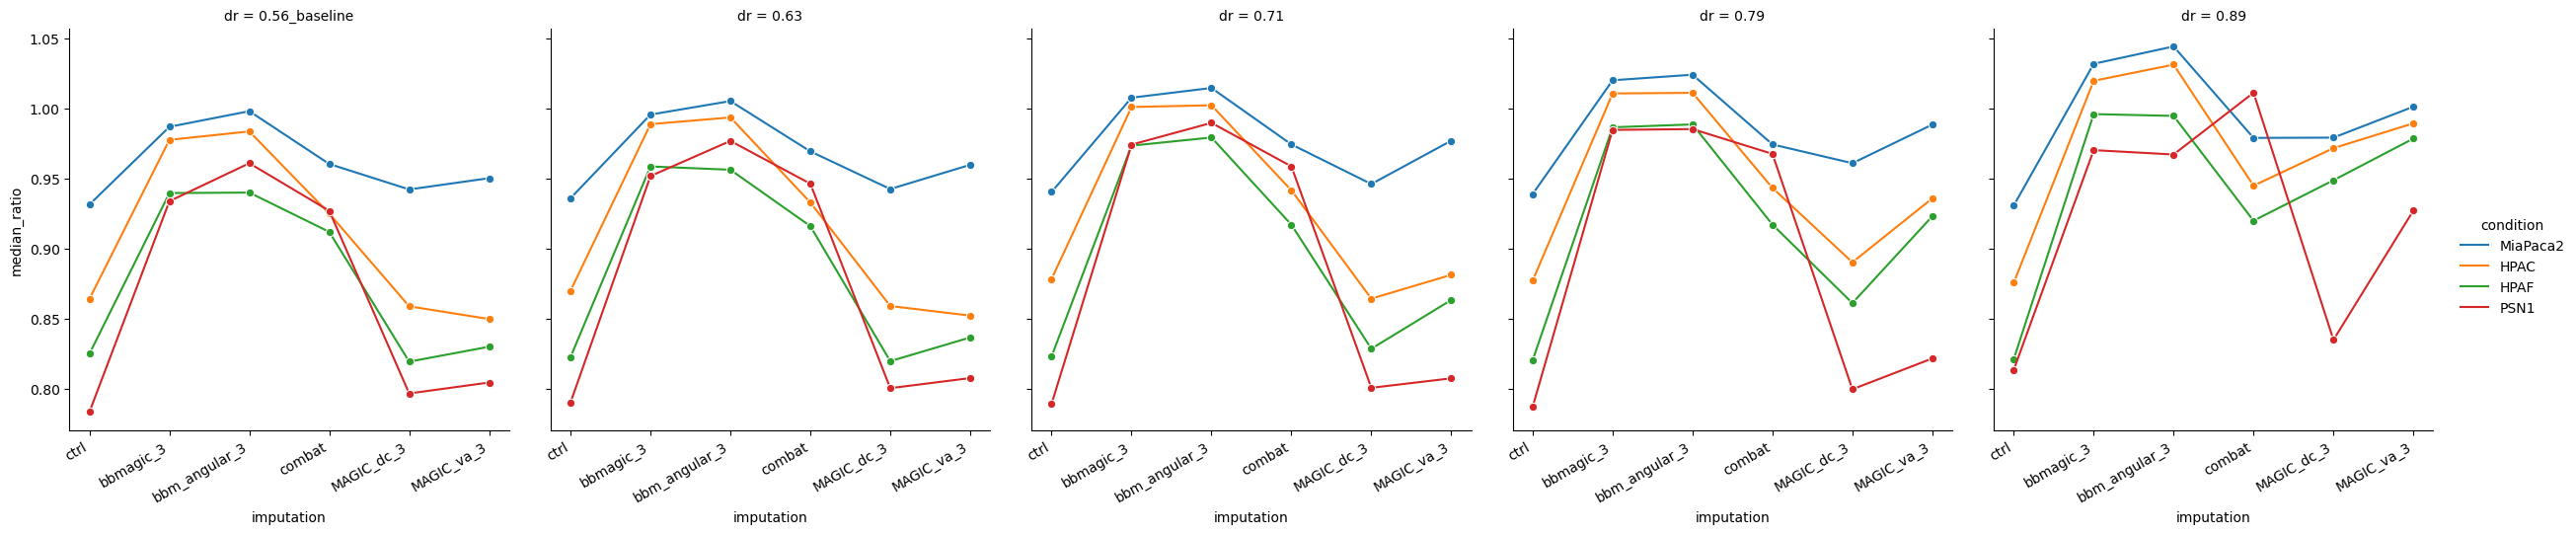

In [93]:
pl = sns.relplot(batch_effect_df, y='median_ratio', hue='condition', x='imputation', col='dr', kind='line', marker="o")
_ = pl.set_xticklabels(rotation=30, ha='right')

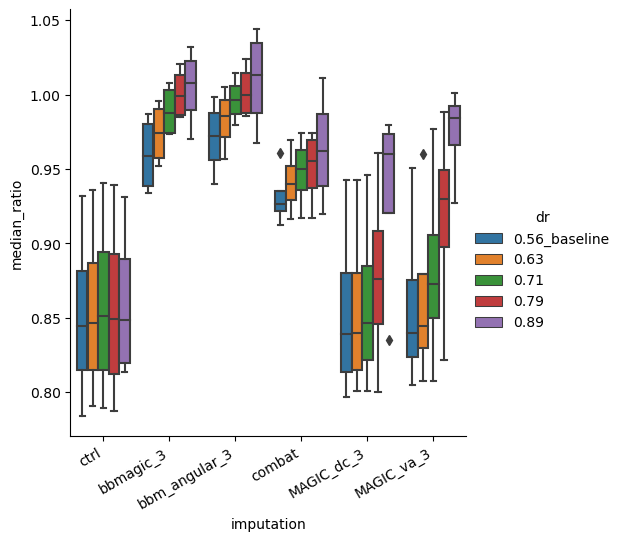

In [94]:
sns.catplot(batch_effect_df, y='median_ratio', x='imputation', hue='dr', kind='box')
_ = plt.xticks(rotation=30, ha='right')

IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2


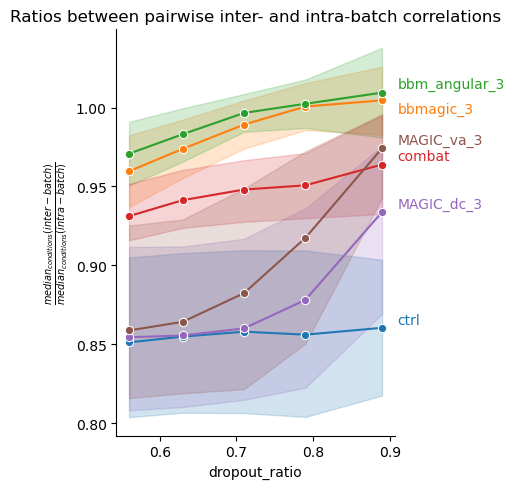

IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2


In [103]:
mr = sns.relplot(batch_effect_df, y='median_ratio', x='dropout_ratio', hue='imputation', kind='line', marker='o')
mr.axes.flat[0].set_title('Ratios between pairwise inter- and intra-batch correlations')
mr.axes.flat[0].set_ylabel(r"$\frac{median_{conditions}(inter-batch)}{median_{conditions}(intra-batch)}$")
sc_imputation_denoising.evaluation.utils.print_labels_on_line_canvas(mr, label_point=-1, offset=0.02, ha='left', exact_x=True, keep_legend=False)

In [ ]:
def get_n_colors(n, palette = 'cividis'):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=n)
    cmap = matplotlib.cm.get_cmap(palette)
    return [matplotlib.colors.to_hex(cmap(norm(i))) for i in range(n)]

def color_columns(obs_df, columns = ["condition", "sample"]):
    color_dict = {}
    for col in columns:
        species = obs_df[col].unique()

        colors = get_n_colors(len(species))
        lut = dict(zip(species, colors))
        color_dict[col] = obs_df[col].map(lut)
    
    return pd.DataFrame(color_dict)
        

In [ ]:
dr = wflow.baseline_key

def plot_correlation_heatmap(adata, layer, method = 'pearson'):    
    
    corr_df_control = pd.DataFrame(
        sc_imputation_denoising.evaluation.utils.correlation_matrix(adata.to_df(layer=layer).T, method=method), 
        index=adata.var_names, 
        columns=adata.var_names
    )

    g = sns.clustermap(
        corr_df_control, 
        cmap = "bwr",
        vmin=-1,
        vmax=1
    )
    g.fig.suptitle(f"Metabolite-metabolite correlations for layer {layer}") 
    
for l in wflow.dataset_dict[dr].layers.keys():
    plot_correlation_heatmap(wflow.dataset_dict[dr], layer=l)



In [3]:
wflow = evaluation_workflow.get_from_pickle('/home/mklein/Dropouts/batch_effects/batch_pickle.pkl')

In [65]:
def _analyse_batch_effects(params):
    l = params
    adata = l['adata'].copy()

    
    all_ions_table = sc.get.obs_df(adata, keys=['batch', 'condition'] + list(adata.var_names))

    all_ions_table['imputation'] = l['imputation']
    all_ions_table['dr'] = l['dropout_ratio']

    return all_ions_table

batch_effect_df = wflow.analyse_imputation(function = _analyse_batch_effects, test_subset=None, n_jobs=48)

100%|██████████| 6/6 [00:00<00:00, 2880.04it/s]


In [22]:
adata_bb = wflow.adata_list[1]['adata'].copy()
adata_bb.obs['group'] = ["epithelial" if i in ['HPAF', 'HPAC'] else "mesenchymal" for i in adata_bb.obs['condition'] ]
# adata_bb.obs[['group', 'condition']].value_counts()

sc.tl.rank_genes_groups(adata_bb, use_raw = False, groupby='group', method='wilcoxon', key_added = f"wilcoxon", reference='epithelial')
deg_df = sc.get.rank_genes_groups_df(adata_bb, group='mesenchymal', key=f"wilcoxon", pval_cutoff=1e-4, log2fc_min=1)
deg_df.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,C36H72NO8P+Na,104.733429,4.048659,0.000000e+00,0.000000e+00
1,C22H44NO6P+H,103.761223,2.267111,0.000000e+00,0.000000e+00
2,C45H77NO9+K,102.123131,3.971068,0.000000e+00,0.000000e+00
3,C35H67O8P+Na,96.241753,3.362999,0.000000e+00,0.000000e+00
4,C33H62O4+H,93.581772,3.147327,0.000000e+00,0.000000e+00
...,...,...,...,...,...
62,C25H46NO7P+Na,32.604942,2.097167,3.490238e-233,6.222494e-233
63,C43H84NO10P+Na,30.945478,1.407255,2.922648e-210,5.057327e-210
64,C47H93N2O6P+H,28.859955,1.635397,3.800435e-183,6.182274e-183
65,C45H88NO10P+Na,27.133345,1.188922,3.981531e-162,6.274467e-162


In [25]:
adata_imp = wflow.adata_list[0]['adata'].copy()
sc.tl.rank_genes_groups(adata_imp, use_raw = False, groupby='batch', method='wilcoxon', key_added = f"wilcoxon", reference='S3')
deg_df = sc.get.rank_genes_groups_df(adata_imp, group='S2', key=f"wilcoxon", pval_cutoff=1e-8)
nonp = [name for name in deg_df.sort_values('logfoldchanges', ascending=False)['names'] if "N" in name and "S" not in name]
out_df = deg_df.sort_values('logfoldchanges', ascending=False)[deg_df['names'].isin(nonp)]
out_df

/tmp/ipykernel_415/1847194701.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  out_df = deg_df.sort_values('logfoldchanges', ascending=False)[deg_df['names'].isin(nonp)]


,names,scores,logfoldchanges,pvals,pvals_adj
63,C55H98NO7P+K,31.471167,31.011950,2.155250e-217,7.608031e-217
41,C47H79NO8+Na,36.159351,8.771398,2.652449e-286,1.397485e-285
42,C42H82NO11P+H,36.159351,8.771398,2.652449e-286,1.397485e-285
45,C44H83NO9+K,35.407227,8.704988,1.321850e-274,6.665902e-274
22,C28H52NO10P+H,52.960621,6.890610,0.000000e+00,0.000000e+00
...,...,...,...,...,...
282,C21H39O6P+Na,-46.646324,-2.685856,0.000000e+00,0.000000e+00
290,C42H80NO8P+Na,-64.847794,-2.793917,0.000000e+00,0.000000e+00
259,C47H90NO10P+Na,-31.531782,-2.963291,3.187091e-218,1.148003e-217
291,C44H84NO8P+Na,-67.115097,-3.558796,0.000000e+00,0.000000e+00


In [66]:
long_batch_df = batch_effect_df.set_index(['imputation', 'condition', 'batch'], append=True)[list(wflow.dataset.var_names)].melt(ignore_index=False).reset_index()
long_batch_df

,cell_id,imputation,condition,batch,variable,value
0,21_S3_W5,ctrl,MiaPaca2,S3,C8HF15O2+H,5.125452
1,24_S3_W5,ctrl,MiaPaca2,S3,C8HF15O2+H,5.378539
2,28_S3_W5,ctrl,MiaPaca2,S3,C8HF15O2+H,5.300285
3,29_S3_W5,ctrl,MiaPaca2,S3,C8HF15O2+H,5.487510
4,31_S3_W5,ctrl,MiaPaca2,S3,C8HF15O2+H,5.228332
...,...,...,...,...,...,...
33025969,2143_S1_W5,bbmagic_8,MiaPaca2,S1,C58H94NO10P+K,1.620528
33025970,2146_S1_W5,bbmagic_8,MiaPaca2,S1,C58H94NO10P+K,1.633897
33025971,2148_S1_W5,bbmagic_8,MiaPaca2,S1,C58H94NO10P+K,1.235360
33025972,2160_S1_W5,bbmagic_8,MiaPaca2,S1,C58H94NO10P+K,1.476926


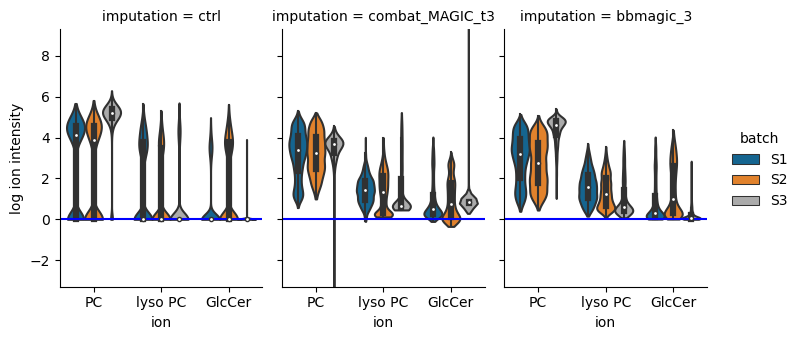

In [33]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')
selected_ions = ['C44H84NO8P+Na', 'C26H48NO7P+H', 'C47H79NO8+Na']
cat = sns.catplot(
    data=long_batch_df, 
    y='value', x='variable', order=selected_ions,
    hue='batch', height=3.5, aspect=0.7,
    kind='violin', cut=0, scale='width', 
    col='imputation', col_wrap=3, col_order=['ctrl', 'combat_MAGIC_t3', 'bbmagic_3'],
)

for ax in cat.axes.flatten():
    ax.set_xticklabels(['PC', 'lyso PC', 'GlcCer'])
    ax.axhline(0, color='blue')
    ax.set_ylim(-3.3,9.3)
cat.set_xlabels("ion")
cat.set_ylabels("log ion intensity")
cat.tight_layout()

cat.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_violins.pdf")

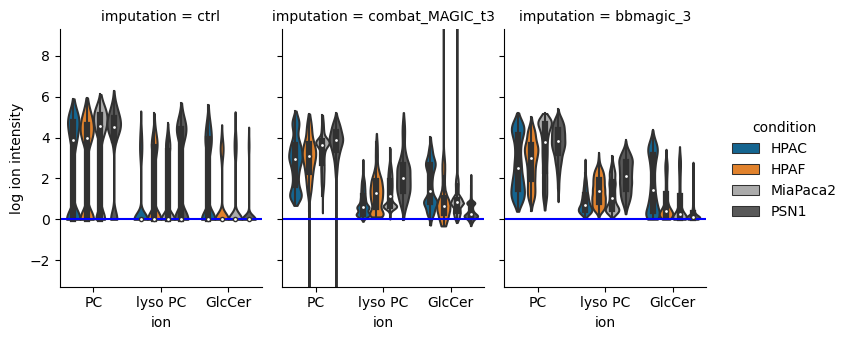

In [34]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')
cat = sns.catplot(
    data=long_batch_df, 
    y='value', x='variable', order=selected_ions,
    hue='condition', height=3.5, aspect=0.7,
    kind='violin', cut=0, scale='width', 
    col='imputation', col_wrap=3, col_order=['ctrl', 'combat_MAGIC_t3', 'bbmagic_3'],
)

for ax in cat.axes.flatten():
    ax.set_xticklabels(['PC', 'lyso PC', 'GlcCer'])
    ax.axhline(0, color='blue')
    ax.set_ylim(-3.3,9.3)
cat.set_xlabels("ion")
cat.set_ylabels("log ion intensity")
cat.tight_layout()

cat.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_violins_cond.pdf")

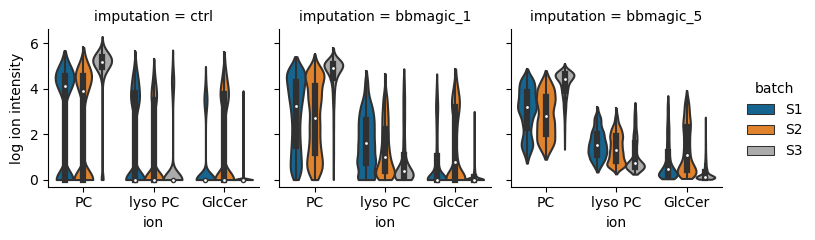

In [71]:
sns.reset_orig()
%matplotlib inline
plt.style.use('tableau-colorblind10')
selected_ions = ['C44H84NO8P+Na', 'C26H48NO7P+H', 'C47H79NO8+Na']
cat = sns.catplot(
    data=long_batch_df, 
    y='value', x='variable', order=selected_ions,
    hue='batch', height=2.5, aspect=1,
    kind='violin', cut=0, scale='width', 
    col='imputation', col_wrap=3, col_order=['ctrl', 'bbmagic_1', 'bbmagic_5'],
)

for ax in cat.axes.flatten():
    ax.set_xticklabels(['PC', 'lyso PC', 'GlcCer'])
cat.set_xlabels("ion")
cat.set_ylabels("log ion intensity")
cat.tight_layout()

cat.savefig("/home/mklein/Dropouts/figures/pancreatic_cancer_batch_effects_violins_incr.pdf")